In this chapter, we identify conditions that justify the use of deep learning and explore the different types of models that can be built such as single step, multi-step, and multioutput models.

We pre-process the data we are going to use throughout the chapter: the time series data and the model we are going to train.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings 
warnings.filterwarnings("ignore") 

In [3]:
df = pd.read_csv(r"C:\Users\user\Downloads\Metro_Interstate_Traffic_Volume.csv")
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
df.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [5]:
df['date_time'] = pd.to_datetime(df['date_time']) #converting date_time column to datetime format 

In [7]:
df = df.drop_duplicates(subset='date_time', ignore_index = True) 
#dropping duplicate values in date_time column 

In [9]:
df.shape 

(40575, 9)

In [11]:
date_range = list(pd.date_range('2012-10-02 09:00:00', '2018-09-30 23:00:00', freq = 'H')) #generating date range for prediction with frequency as 'H' (hourly)

print(len(date_range))

52551


In [13]:
new_df = pd.DataFrame({'date_time':date_range}) #creating a new dataframe with 'date_time' column 

new_df.head()

,date_time
0,2012-10-02 09:00:00
1,2012-10-02 10:00:00
2,2012-10-02 11:00:00
3,2012-10-02 12:00:00
4,2012-10-02 13:00:00


In [16]:
full_df = pd.merge(new_df, df, how= 'left', on='date_time') #merging the two dataframes using 'date_time' column


In [17]:
full_df.shape

(52551, 9)

In [18]:
full_df.head() #notice the date_time column is merged to the left of the dataframe 

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2012-10-02 09:00:00,NaN,288.28,0.0,0.0,40.0,Clouds,scattered clouds,5545.0
1,2012-10-02 10:00:00,NaN,289.36,0.0,0.0,75.0,Clouds,broken clouds,4516.0
2,2012-10-02 11:00:00,NaN,289.58,0.0,0.0,90.0,Clouds,overcast clouds,4767.0
3,2012-10-02 12:00:00,NaN,290.13,0.0,0.0,90.0,Clouds,overcast clouds,5026.0
4,2012-10-02 13:00:00,NaN,291.14,0.0,0.0,75.0,Clouds,broken clouds,4918.0


In [19]:
full_df.isna().sum() #checking for null values in the full dataframe

date_time                  0
holiday                52498
temp                   11976
rain_1h                11976
snow_1h                11976
clouds_all             11976
weather_main           11976
weather_description    11976
traffic_volume         11976
dtype: int64

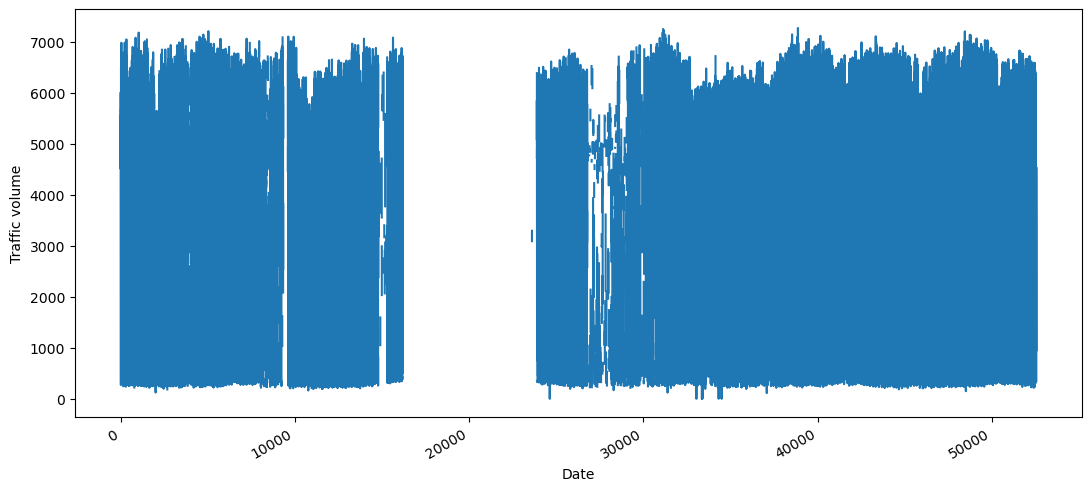

In [20]:
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(full_df.traffic_volume)
ax.set_xlabel('Date')
ax.set_ylabel('Traffic volume')

fig.autofmt_xdate()
plt.show()

In [21]:
full_df[35000:].isna().sum() #checking for null values after 35000 rows 


date_time                  0
holiday                17529
temp                     104
rain_1h                  104
snow_1h                  104
clouds_all               104
weather_main             104
weather_description      104
traffic_volume           104
dtype: int64

In [23]:
full_df = full_df[35000:].reset_index(drop=True) 

#dropping null values after 35000 rows 

In [24]:
full_df.head()

,date_time,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume
0,2016-09-29 17:00:00,NaN,291.75,0.0,0.0,0.0,Clear,Sky is Clear,5551.0
1,2016-09-29 18:00:00,NaN,290.36,0.0,0.0,0.0,Clear,Sky is Clear,4132.0
2,2016-09-29 19:00:00,NaN,287.86,0.0,0.0,0.0,Clear,Sky is Clear,3435.0
3,2016-09-29 20:00:00,NaN,285.91,0.0,0.0,0.0,Clear,Sky is Clear,2765.0
4,2016-09-29 21:00:00,NaN,284.31,0.0,0.0,0.0,Clear,Sky is Clear,2443.0


In [25]:
#drop 'holiday, 'weather_main', 'weather_description' columns

full_df = full_df.drop(['holiday', 'weather_main', 'weather_description'], axis=1)
full_df.shape 

(17551, 6)

In [27]:
#fill NA  values with median

full_df = full_df.fillna(full_df.groupby(full_df.date_time.dt.hour).transform('median'))

In [28]:
full_df.isna().sum() 

date_time         0
temp              0
rain_1h           0
snow_1h           0
clouds_all        0
traffic_volume    0
dtype: int64

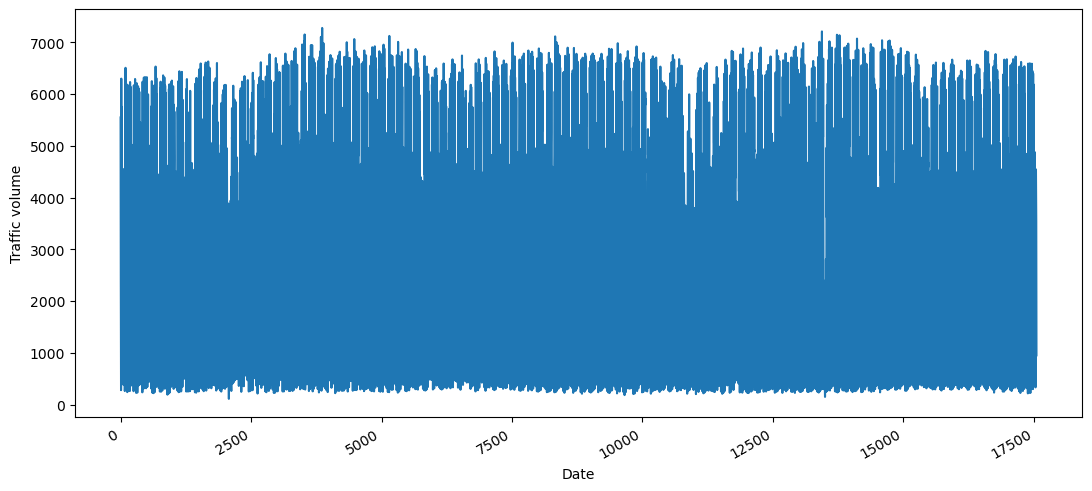

In [29]:
fig, ax = plt.subplots(figsize=(13,6))

ax.plot(full_df.traffic_volume)
ax.set_xlabel('Date')
ax.set_ylabel('Traffic volume')

fig.autofmt_xdate()
plt.show()

In [31]:
#Convert full_df to CSV 

full_df.to_csv ('traffic_volume_preprocessed.csv', index = False, header=True)

Data Exploration 

In [32]:
df = pd.read_csv(r"C:\Users\user\ML Resources-code\Machine-Learning\Deep Learning Time Series Forecasting\traffic_volume_preprocessed.csv")
df.head()

,date_time,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,2016-09-29 17:00:00,291.75,0.0,0.0,0.0,5551.0
1,2016-09-29 18:00:00,290.36,0.0,0.0,0.0,4132.0
2,2016-09-29 19:00:00,287.86,0.0,0.0,0.0,3435.0
3,2016-09-29 20:00:00,285.91,0.0,0.0,0.0,2765.0
4,2016-09-29 21:00:00,284.31,0.0,0.0,0.0,2443.0


the dataset starts on September 29, 2016, at 5 p.m. and ends on September 30, 2018, at 11 p.m. Using
df.shape, we can see that we have a total of six features and 17,551 rows.

Let us understand our variables: rain_1h = amount of rain occured in the hour(mm), same as snow_1h. 

temp = temp recorded in the hour, in Kelvin. clouds_all = percentage of cloud cover during the hour. traffic_volume = volume f traffic reported westbound during the hour. 

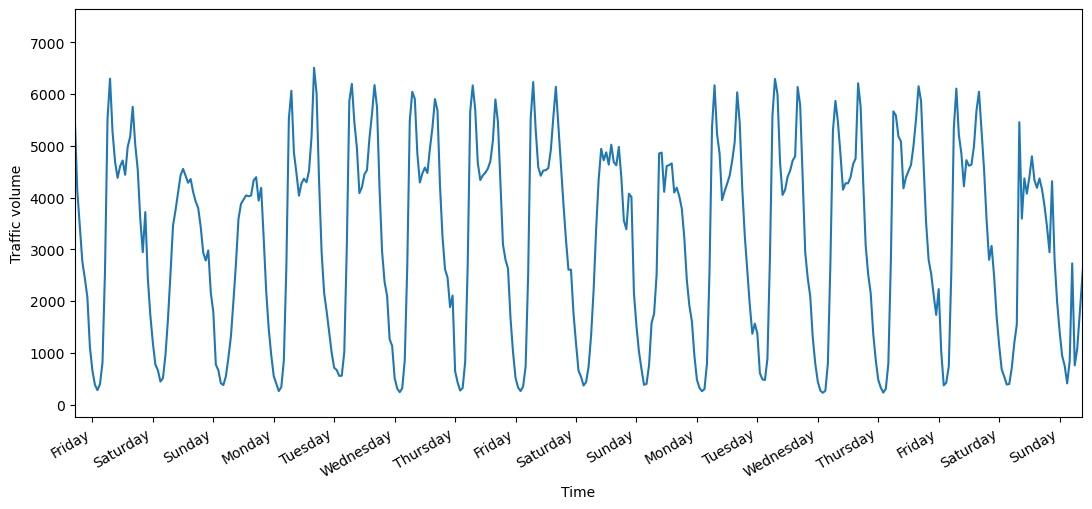

In [34]:
#let us plot 400 data points from the dataset, equivalent to 2 weeks of data

fig, ax = plt.subplots(figsize= (13,6))

ax.plot(df['traffic_volume'])
ax.set_xlabel('Time')
ax.set_ylabel('Traffic volume')

plt.xticks(np.arange(7, 400, 24),['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                   'Friday','Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.xlim(0, 400)

fig.autofmt_xdate()
plt.show()

There is seasonality considering trafic volume is usually lower at the start and end of each day and we also notice it is smaller during the weekeends. Yet the volume is neither increasing nor decreasing.

On plotting the hourly temp,which is our target for multioutput models, we expect to see both yearly and daily seasonality. Daily seasonality is due to the fact that temps tend to be lower at night and higher during the day  

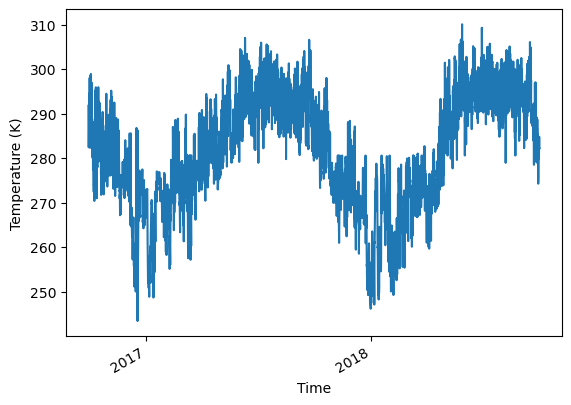

In [35]:
#Plotting hourly temp over the entire dataset 

fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks([2239, 10999], [2017, 2018]) 

fig.autofmt_xdate()
plt.show()

According to the grap abve, we see a yearly seasonality that corresponds with the Minnesota weather pattern;temps are lower at the start and end of the year, higherduring summer which is the middle of the year. Let's confirm if we can observe daily seasonality in temperature.  

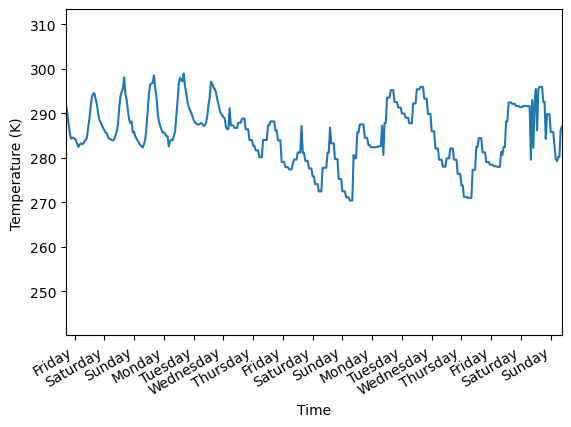

In [37]:
fig, ax = plt.subplots()

ax.plot(df['temp'])
ax.set_xlabel('Time')
ax.set_ylabel('Temperature (K)')

plt.xticks(np.arange(7, 400, 24),['Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
                                   'Friday','Saturday','Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.xlim(0, 400)
fig.autofmt_xdate()
plt.show()


We canobserve that the temp is lower during the start and end of the day and higher during the middle of the day.

----------------------------------------------------------------------------------------------

Feature Engineering and Data Splitting 

The first step to study the features of a dataset is to use the describe method from
pandas. This method returns the number of records for each feature, allowing us to quickly identify missing values, the mean, standard deviation, quartiles, and maximum
and minimum values for each feature.

In [38]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,17551.0,281.416203,12.688262,243.39,272.22,282.41,291.89,310.07
rain_1h,17551.0,0.025523,0.259794,0.00,0.00,0.00,0.00,10.60
snow_1h,17551.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00
clouds_all,17551.0,42.034129,39.065960,0.00,1.00,40.00,90.00,100.00
traffic_volume,17551.0,3321.484588,1969.223949,113.00,1298.00,3518.00,4943.00,7280.00


rain and snow are mostly 0 throughought the dataset therefore we can drop them as features.

In [39]:
cols_to_drop = ['snow_1h', 'rain_1h']
df = df.drop(cols_to_drop, axis = 1)

Convert datetime string by encoding it to numerical values. We can express the date as a number of seconds. This makes us lose the cyclical nature of the time series, because number of seconds simply increases linearly with time.

We will then apply a transformation to recover the cyclical behavior of time by applying a sine transformation, because the sine function is cyclical, bound btn -1 and 1. 

In [41]:
import datetime 

timestamp_s = pd.to_datetime(df['date_time']).map(datetime.datetime.timestamp)

In [42]:
day = 24 * 60 * 60 #number of seconds in a day calculated since timestamp is in seconds 

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))) #we used radians in the sine function


At this point, 12 pm is equivalent to 12 a.m and 5 pm equivalent to 5 a.m and this is not desired. Therefore we apply a cosine transformation to disinguish btn 5am and 5pm, since cosine is out of phase with sine function. 

In [44]:
df['day_cos'] = (np.cos(timestamp_s * (2 * np.pi/day))).values

df = df.drop(['date_time'], axis = 1) #dropping the date_time column

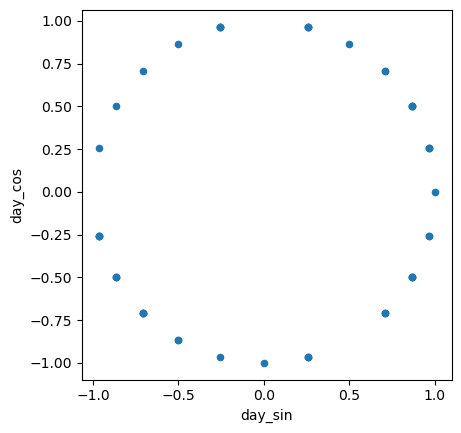

In [45]:
df.sample(50).plot.scatter('day_sin', 'day_cos').set_aspect('equal') 

We have succesfully expressed each time stamp as a point on the clock. We now have values that retain the cyclical nature of time in a day 

Split data to train,validation and test sets

In [46]:
n = len(df)

#split 70:20:10 train:test:validation set

train_df = df[0:int(n*0.7)] #first 70% goes to train set

val_df = df[int(n*0.7):int(n*0.9)] #next 20% goes to validation set

test_df = df[int(n*0.9):] #last 10% goes to test set

Scale our data so all values are btn 0 and 1, decreasing training time and increasing performance. We will fit the scaler to the train set so that the evaluation of the model remains unbiased.  

In [48]:
from sklearn.preprocessing import MinMaxScaler 

scaler =  MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])

val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])

test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

#scaling simply forces all these values to be between 0 and 1 

In [49]:
#save each set as a CSV file for our next chapter 

train_df.to_csv('train.csv', index = False)

val_df.to_csv('val.csv', index = False)

test_df.to_csv('test.csv', index = False)